# Projet Python ENSAE

## Tokenisation d'actifs immobiliers

Lien projet: https://hureauxarnaud.medium.com/projet-estimateur-de-prix-dun-bien-immobilier-bas%C3%A9-sur-du-machine-learning-ae578fdacaca

Code : https://colab.research.google.com/drive/1bU1Nx0HcLSSf1U6BVvsiYFfrJeKnhIW2?usp=sharing#scrollTo=GWGxYN3LKLu8   

# Etape 0 : packages

In [51]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.neighbors import BallTree
import requests
import matplotlib

In [33]:
""" 

url = 'https://github.com/InseeFrLab/Py-Insee-Data/archive/refs/heads/master.zip'
r = requests.get(url)
with open("pynsee.zip" , 'wb') as zipfile:
    zipfile.write(r.content)

!pip install --ignore-installed pynsee.zip
!pip install python-Levenshtein

"""

' \n\nurl = \'https://github.com/InseeFrLab/Py-Insee-Data/archive/refs/heads/master.zip\'\nr = requests.get(url)\nwith open("pynsee.zip" , \'wb\') as zipfile:\n    zipfile.write(r.content)\n\n!pip install --ignore-installed pynsee.zip\n!pip install python-Levenshtein\n\n'

In [62]:
# Get the development version from GitHub
# git clone https://github.com/InseeFrLab/Py-Insee-Data.git
# cd Py-Insee-Data
# pip install .
# pip install --ignore-installed pynsee.zip
# pip install xlrd
# pip install python-Levenshtein

In [3]:
# import pynsee
# import pynsee.download
# from pynsee.download import telechargerDonnees

In [4]:
# df_city_2015 = telechargerDonnees("FILOSOFI_COM", date = "2015")

In [5]:
# Variable nombre de personnes: `NBPERSMENFISC16`
# df_city_2015.sample(5)

# Etape 1 : preprocessing

### 1.1. Importation du dataset DVF :

Nous importons le dataset « **Demandes de valeurs foncières** » (DVF), publié par la DGFiP, permet de connaître les transactions immobilières intervenues au cours des cinq dernières années sur le territoire métropolitain et les DOM-TOM, à l’exception de l’Alsace, de la Moselle et de Mayotte. Les données contenues sont issues des actes notariés et des informations cadastrales.

Fichiers 2017-2020 : https://files.data.gouv.fr/geo-dvf/latest/

In [88]:
# Les fichiers sont issus de https://files.data.gouv.fr/geo-dvf/latest/

name = "https://files.data.gouv.fr/geo-dvf/latest/csv/2021/full.csv.gz"
table = pd.read_csv(name, sep = ',')

# Pour l'instant, on ne travaille que sur les données de 2021, mais il conviendra d'enlever les guillemets par la suite...

"""
for year in range(2017, 2021):
    name = "https://files.data.gouv.fr/geo-dvf/latest/csv/" + str(year) + "/full.csv.gz"
    table = pd.concat([table, pd.read_csv(name, sep = ',')])

display("Taille de table :")
display(table.shape)
table.head()
"""

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (10,12,17,18,20,22,24,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


'\nfor year in range(2017, 2021):\n    name = "https://files.data.gouv.fr/geo-dvf/latest/csv/" + str(year) + "/full.csv.gz"\n    table = pd.concat([table, pd.read_csv(name, sep = \',\')])\n\ndisplay("Taille de table :")\ndisplay(table.shape)\ntable.head()\n'

### 1.2. Visualisation des données

A compléter : il s'agit d'avoir **des premières intuitions sur les données**. 

Notamment, il faudra visualiser sur une carte, **faire des analyses descriptives** (moyennes, variances, etc.) au niveau national et par région ou dans les grandes villes (cf. l'étape 2).

En particulier, on se rend compte du **problème de preprocessing** mentionné plus haut : une transaction correspond à plusieurs lignes.
Ainsi, si on entraîne l'algorithme de pricing sur ce dataset, il sera **biaisé** : 
* d'une part, il associerait à une dépendance de 20 m2 le prix d'un appartement de 200 m2
* d'autre part, il ne prendrait pas en compte la plus-value apportée par un jardin à une maison, par une dépendance à un appartement, etc.

Il conviendra donc de **retravailler les données pour obtenir une seule ligne par transaction**.

In [89]:
# Colonnes du dataset

print("Voici les colonnes de table :")
display(table.columns)

Voici les colonnes de table :


Index(['id_mutation', 'date_mutation', 'numero_disposition', 'nature_mutation',
       'valeur_fonciere', 'adresse_numero', 'adresse_suffixe',
       'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'code_commune',
       'nom_commune', 'code_departement', 'ancien_code_commune',
       'ancien_nom_commune', 'id_parcelle', 'ancien_id_parcelle',
       'numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero',
       'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez',
       'lot4_numero', 'lot4_surface_carrez', 'lot5_numero',
       'lot5_surface_carrez', 'nombre_lots', 'code_type_local', 'type_local',
       'surface_reelle_bati', 'nombre_pieces_principales',
       'code_nature_culture', 'nature_culture', 'code_nature_culture_speciale',
       'nature_culture_speciale', 'surface_terrain', 'longitude', 'latitude'],
      dtype='object')

In [90]:
# Création d'une adresse générique

table['adresse_numero'] = table['adresse_numero'].fillna('0').astype(int)
table['adresse_suffixe'] = table['adresse_suffixe'].fillna(' ')
table['adresse_code_voie'] = table['adresse_code_voie'].fillna(' ')
table['adresse_nom_voie'] = table['adresse_nom_voie'].fillna(' ')
table['code_postal'] = table['code_postal'].fillna('0').astype(int)
table['nom_commune'] = table['nom_commune'].fillna(' ')

table["adresse"] = table['adresse_numero'].astype(str) + ' ' + table['adresse_suffixe'] + ' ' + table['adresse_code_voie'] + ' ' + table['adresse_nom_voie'] + ' ' + table['nom_commune'] + ' ' + table['code_postal'].astype(str) + ' ' + 'France'

# Création d'un identifiant de transaction
# Pour identifier les doublons, l'adresse ne suffit pas : un bien peut avoir été vendu deux fois dans la même année

table["identifiant_transaction"] = table["adresse"].astype(str) + ' le ' + table["date_mutation"].astype(str)

In [91]:
# Problème dans les données et vérification de la validité de l'identifiant de transaction :

display(table["identifiant_transaction"].loc[0])
display(table["identifiant_transaction"].loc[1])
display("Si l'identifiant de transaction est valide, alors True doit s'afficher :")
table["identifiant_transaction"].loc[0] == table["identifiant_transaction"].loc[1]

'5080   0471 CHE DE VOGELAS Val-Revermont 1370 France le 2021-01-05'

'5080   0471 CHE DE VOGELAS Val-Revermont 1370 France le 2021-01-05'

"Si l'identifiant de transaction est valide, alors True doit s'afficher :"

True

**Problème de preprocessing** : le dataset affiche le même prix de vente global à chaque lot.

En effet, d'après la **notice descriptive** : 
* Les lots, notion juridique immobilière, sont définis dans un état descriptif de division (EDD) et dans les documents de mutation. Ils permettent d’identifier une partie d’un immeuble et ainsi d’y associer un droit de propriété spécifique (propriété, usufruit, etc.).
* Les locaux, notion fiscale, identifient les mêmes parties d’un immeuble pour les besoins de la taxe foncière et de la taxe d’habitation en regroupant plusieurs lots.
* La correspondance entre le découpage en lots et en locaux n’est pas retracée.

Donc, quand une disposition comporte plusieurs locaux ou plusieurs natures de culture, **le fichier de restitution comporte autant de lignes qu’il y a de locaux ou de nature de culture concernés par la mutation**. Ainsi, pour une même publication, il peut y avoir 1 à n ligne(s) de restitution. **Les données génériques (ainsi que le prix) sont alors répétées sur chaque ligne**.

Voici les types de locaux différents : 
['Dépendance', 'Appartement', 'Maison', nan, 'Local industriel. commercial ou assimilé']
On ne peut pas juste enlever les "Dépendances". En effet, ces dernières peuvent avoir un effet (haussier) sur le prix de vente.

Par ailleurs, une maison avec un jardin fait l'objet de deux lignes ayant la même valeur foncière mais des surfaces différentes (celle de la maison, celle du jardin) : suivant la colonne nature_culture ([nan, 'sols', "terrains d'agrément", 'taillis simples', 'terrains a bâtir', 'eaux', 'landes', 'taillis sous futaie', 'prés', 'terres', 'jardins', 'peupleraies', 'vignes', 'bois', 'vergers', 'carrières', 'futaies résineuses', 'pâtures', 'futaies feuillues', 'futaies mixtes', 'chemin de fer', 'oseraies', 'pacages', 'prés plantes', 'terres plantées', 'landes boisées', 'herbages', "prés d'embouche"]).

Il conviendra donc d'**agréger dans une ligne ces informations** :
* l'actif immobilier a-t-il une dépendance ? si oui, de combien de m2 ?
* la maison a-t-elle un jardin ? si oui, de combien de m2 ?

In [92]:
# On constate, encore une fois, le problème relevé ci-dessus :

display("Nombre d'adresses uniques dans le DataFrame :")
display(len(table["adresse"].unique()))
display("Nombre d'identifiant_transaction uniques dans le DataFrame :")
display(len(table["identifiant_transaction"].unique()))
display("Nombre de lignes dans le DataFrame :")
display(len(table))
display("Nombre moyen de lignes par vente :")
np.round(len(table) / len(table["identifiant_transaction"].unique()), 2)

# Une vente correspond à plusieurs lignes, les informations sont donc diffusées dans ces lignes...

"Nombre d'adresses uniques dans le DataFrame :"

547234

"Nombre d'identifiant_transaction uniques dans le DataFrame :"

654843

'Nombre de lignes dans le DataFrame :'

1210569

'Nombre moyen de lignes par vente :'

1.85

### 1.3. Création du dataset final :

Nous ne prenons que les colonnes suivantes :
- Date de vente/mutation
- Nature mutation (pour séparer les ventes en VEFA et les ventes classiques)
- Valeur foncière (prix de vente)
- Colonnes liées à l’adresse (pour nous permettre de localiser le bien)
- Adresse
- Code Postal
- Type local (maison/appartement/Local commercial/Dépendance etc)
- Surface réelle bâtie (nb de mètre carré du bien bâti)
- Surface terrain (nb de mètre carré du terrain associé au bien)

In [93]:
# Création de table_vf :

# On crée le dataframe table_vf qui sera la version finale (vf) de notre dataset
colonnes = ["date_mutation", "nature_mutation", "valeur_fonciere", "code_postal", "code_departement", 'type_local',
            'surface_reelle_bati', 'nombre_pieces_principales', 'nature_culture', 'surface_terrain', 'longitude', 
            'latitude', 'adresse', 'code_departement', 'identifiant_transaction']
table_vf = table[colonnes].copy()

# On agrège les types de cultures différents de NaN, sols, terrain à bâtir et  : on les renomme "culture"
culture_type = ['taillis simples', 'eaux', 'landes', 'taillis sous futaie', 'prés', 'terres', 'peupleraies', 
                'vignes', 'bois', 'vergers', 'carrières', 'futaies résineuses', 'pâtures', 'futaies feuillues', 
                'futaies mixtes', 'chemin de fer', 'oseraies', 'pacages', 'prés plantes', 'terres plantées', 
                'landes boisées', 'herbages', "prés d'embouche"]
for x in culture_type:
    table_vf.loc[table_vf["nature_culture"] == x, "nature_culture"] = "culture"

# Visualisation de table_vf
display(table_vf.shape)
display("Les quatre premières lignes")
display(table_vf.head(4))
display("Les quatre dernières lignes")
table_vf.tail(4)

(1210569, 15)

'Les quatre premières lignes'

,date_mutation,nature_mutation,valeur_fonciere,code_postal,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,adresse,code_departement,identifiant_transaction
0,2021-01-05,Vente,185000.0,1370,1,Maison,97.0,5.0,sols,2410.0,5.386094,46.327140,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...,1,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...
1,2021-01-05,Vente,185000.0,1370,1,Dépendance,NaN,0.0,sols,2410.0,5.386094,46.327140,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...,1,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...
2,2021-01-06,Vente,10.0,1290,1,NaN,NaN,NaN,culture,530.0,4.844368,46.224233,0 B043 ROUGEMONT Bey 1290 France,1,0 B043 ROUGEMONT Bey 1290 France le 2021-01-06
3,2021-01-04,Vente,204332.0,1310,1,Maison,88.0,4.0,sols,866.0,5.157688,46.200988,7 0276 ALL DES ECUREUILS Buellas 1310 France,1,7 0276 ALL DES ECUREUILS Buellas 1310 France...


'Les quatre dernières lignes'

,date_mutation,nature_mutation,valeur_fonciere,code_postal,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,adresse,code_departement,identifiant_transaction
1210565,2021-03-17,Vente,260000.0,75002,75,Appartement,37.0,2.0,NaN,NaN,2.350774,48.868450,8 8561 RUE SAINTE FOY Paris 2e Arrondissemen...,75,8 8561 RUE SAINTE FOY Paris 2e Arrondissemen...
1210566,2021-03-19,Vente,38000.0,75004,75,Dépendance,NaN,0.0,NaN,NaN,2.357623,48.858041,6 4398 RUE DES GUILLEMITES Paris 4e Arrondis...,75,6 4398 RUE DES GUILLEMITES Paris 4e Arrondis...
1210567,2021-03-30,Vente,38000.0,75004,75,Dépendance,NaN,0.0,NaN,NaN,2.365430,48.852861,30 7338 RUE DU PETIT MUSC Paris 4e Arrondiss...,75,30 7338 RUE DU PETIT MUSC Paris 4e Arrondiss...
1210568,2021-03-19,Vente,690000.0,75002,75,Local industriel. commercial ou assimilé,56.0,0.0,NaN,NaN,2.345110,48.868196,3 8659 RUE SAINT-JOSEPH Paris 2e Arrondissem...,75,3 8659 RUE SAINT-JOSEPH Paris 2e Arrondissem...


**1.3.1. Création de deux dataframes**

In [94]:
# On crée deux dataframes :
# * un dataframe avec les transactions non dupliquées
# * un dataframe avec les transactions dupliquées (sur lequel il faudra travailler pour parvenir à : une transaction = une ligne)

table_vf_dup = table_vf.copy()
table_vf_uni = table_vf.copy()
print("Taille de table_vf_uni :")
print(table_vf_uni.shape)

# On récupère les indices des transactions dupliquées (pour lesquelles il y a 
dup_id = table_vf_dup.groupby('identifiant_transaction').size()
dup_id = dup_id[dup_id > 1]
dup_id = dup_id.reset_index()
print("Voici à quoi ressemble dup_id :")
display(dup_id.sample(5))

table_vf_dup = table_vf_dup[table_vf_dup['identifiant_transaction'].isin(dup_id["identifiant_transaction"])]
print("Voici à quoi ressemble table_vf_dup :")
display(table_vf_dup.head())
print("Taille de table_vf_dup :")
display(table_vf_dup.shape)

table_vf_uni = table_vf_uni[~table_vf_uni['identifiant_transaction'].isin(dup_id["identifiant_transaction"])]
print("Voici à quoi ressemble table_vf_uni :")
display(table_vf_uni.sample(5))
print("Taille de table_vf_uni :")
display(table_vf_uni.shape)

Taille de table_vf_uni :
(1210569, 15)
Voici à quoi ressemble dup_id :


,identifiant_transaction,0
105146,10 0450 RUE DU STADE La Talaudière 42350 Fra...,3
265497,936 B025 CAYE NORD Bourg 33710 France le 202...,2
30681,0 B022 FONTROUCH Molières-Cavaillac 30120 Fr...,2
215811,5052 B003 BEUVARDELLE Beuvardes 2130 France ...,2
265393,93 8755 AV VICTOR HUGO Valence 26000 France ...,2


Voici à quoi ressemble table_vf_dup :


,date_mutation,nature_mutation,valeur_fonciere,code_postal,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,adresse,code_departement,identifiant_transaction
0,2021-01-05,Vente,185000.0,1370,1,Maison,97.0,5.0,sols,2410.0,5.386094,46.327140,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...,1,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...
1,2021-01-05,Vente,185000.0,1370,1,Dépendance,NaN,0.0,sols,2410.0,5.386094,46.327140,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...,1,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...
4,2021-01-06,Vente,320000.0,1250,1,Maison,168.0,5.0,sols,1426.0,5.273260,46.156334,87 0140 RTE DE CERTINES Montagnat 1250 France,1,87 0140 RTE DE CERTINES Montagnat 1250 Franc...
5,2021-01-06,Vente,320000.0,1250,1,Dépendance,NaN,0.0,sols,1426.0,5.273260,46.156334,87 0140 RTE DE CERTINES Montagnat 1250 France,1,87 0140 RTE DE CERTINES Montagnat 1250 Franc...
7,2021-01-04,Vente,176000.0,1000,1,Dépendance,NaN,0.0,NaN,NaN,5.200117,46.210292,210 0820 RUE GEORGE SAND Saint-Denis-lès-Bou...,1,210 0820 RUE GEORGE SAND Saint-Denis-lès-Bou...


Taille de table_vf_dup :


(823100, 15)

Voici à quoi ressemble table_vf_uni :


,date_mutation,nature_mutation,valeur_fonciere,code_postal,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,adresse,code_departement,identifiant_transaction
459978,2021-01-06,Vente,313000.0,42000,42,Local industriel. commercial ou assimilé,151.0,0.0,NaN,NaN,4.397839,45.457721,15 7343 RUE DE LA PRESSE Saint-Étienne 42000...,42,15 7343 RUE DE LA PRESSE Saint-Étienne 42000...
1169051,2021-03-26,Vente,57000.0,97231,972,NaN,NaN,NaN,terrains a bâtir,77.0,-60.933914,14.659374,0 B145 FOUR A CHAUX Le Robert 97231 France,972,0 B145 FOUR A CHAUX Le Robert 97231 France l...
404448,2021-05-05,Vente,42.0,36800,36,Maison,86.0,4.0,sols,450.0,1.488159,46.627209,15 0120 ALL DU PARC Le Pont-Chrétien-Chabene...,36,15 0120 ALL DU PARC Le Pont-Chrétien-Chabene...
381233,2021-03-30,Vente,73200.0,35850,35,NaN,NaN,NaN,terrains a bâtir,488.0,-1.880431,48.217954,0 C081 LE REBOURS Romillé 35850 France,35,0 C081 LE REBOURS Romillé 35850 France le 20...
260312,2021-04-22,Vente,105000.0,30250,30,NaN,NaN,NaN,terrains a bâtir,642.0,4.062254,43.839151,0 B010 LES CAMINADES Lecques 30250 France,30,0 B010 LES CAMINADES Lecques 30250 France le...


Taille de table_vf_uni :


(387469, 15)

### Rapport de mi-parcours pre-processing :

Jusqu'ici, nous avons obtenu que :
* le dataset initial (1 210 569 lignes) comporte **des erreurs qui nous empêchent de l'exploiter directement** ;
* en effet, on distingue les transactions qui n'ont fait l'objet que d'**une seule ligne** (car il n'y avait pas de bien secondaire) des transactions qui font l'objet de **plusieurs lignes** (car il y a un ou plusieurs biens secondaires) : au total il n'y a eu que **654 843 transactions** (soit environ 1,85 lignes par transaction en moyenne).

Nous avons ainsi créé **deux datasets** :
* un dataset (**table_vf_uni**) avec uniquement les transactions n'ayant fait l'objet que d'une seule ligne (387 469 lignes) ;
* un dataset (**table_vf_dup**) avec uniquement les transactions ayant fait l'objet de plusieurs lignes (823 100 lignes).

Ainsi, nous avons désormais **deux options** :
* nous pouvons *entraîner notre algorithme de pricing sur les transactions n'ayant fait l'objet que d'une seule ligne* (cela exclut par exemple les appartements avec une cave, les maisons avec un jardin d'agrément, etc.) -> cela représente tout de même près de 400 000 transactions en 2021 (60 % des transactions environ).
* nous *continuons notre travail de preprocessing pour traiter le dataset table_vf_dup* avec les transactions dupliquées (40 % des transactions environ).

Comme le traitement du dataset des transactions dupliquées est compliqué, nous avons choisi d'**étudier les deux possibilités** :
* d'abord il conviendra de vérifier que les transactions ayant fait l'objet d'une ligne unique sont **représentatives du marché immobilier français** avant d'entraîner notre algorithme avec,
* ensuite, nous pourrons **traiter le dataset des transactions dupliquées** et réentraîner notre algorithme avec ces nouvelles données.
* nous pourrons enfin **comparer les performances des deux modèles**.

**1.3.2. Traitement du dataset de transactions dupliquées :**

In [95]:
# Visualisation des colonnes principales d'intérêt pour le preprocessing :

print("* Différentes valeurs dans 'type_local' :")
display(table_vf_dup['type_local'].unique())
print("* Différentes valeurs dans 'nature_culture' :")
display(table_vf_dup['nature_culture'].unique())

* Différentes valeurs dans 'type_local' :


array(['Maison', 'Dépendance', 'Appartement', nan,
       'Local industriel. commercial ou assimilé'], dtype=object)

* Différentes valeurs dans 'nature_culture' :


array(['sols', nan, 'culture', 'terrains a bâtir', 'jardins',
       "terrains d'agrément"], dtype=object)

In [96]:
# Objectif : créer des colonnes pour stocker les valeurs des biens secondaires (jardin, terrain à bâtir, dépendance, etc.)
# On veut le nombre de m2 de la culture (s'il ne s'agit pas d'un jardin / terrain d'agrément ou d'un terrain à bâtir), 
# On veut aussi le nombre de m2 du local (une dépendance ou un local industriel, par exemple), du terrain à bâtir et du jardin

table_vf_dup["culture_m2"] = 0
table_vf_dup["jardin_m2"] = 0
table_vf_dup["terrains_a_bâtir_m2"] = 0
table_vf_dup["dependance_m2"] = 0

In [97]:
# Création d'une fonction de stockage des valeurs diffuses :

def stockage_function(table_vf, table, indexes : list, saved_line_index):
    
    # On se place sur chaque "ligne supplémentaire"
    for index in indexes:
        
        # On regarde d'abord si la nature du bien à la ligne index est la même que celle de la ligne de référence retenue
        # S'il s'agit de la même nature de bien, c'est qu'on a eu une duplication ("le fichier de restitution comportera (n x p) lignes")
        if table.loc[index, "type_local"] == table.loc[saved_line_index, "type_local"] and table.loc[index, "type_local"] != "Nan":
            return table_vf
        
        # Sinon, on continue l'exploration...
        else:
            # On regarde s'il s'agit d'une dépendance ou d'un local industriel ou commercial
            if table.loc[index, "type_local"] == "Dépendance":
                if table_vf["surface_reelle_bati"][index] != "NaN":
                    table_vf["dependance_m2"][saved_line_index] += table_vf["surface_reelle_bati"][index]
                if table_vf["surface_terrain"][index] != "NaN":
                    table_vf["dependance_m2"][saved_line_index] += table_vf["surface_terrain"][index]
            elif table_vf_dup.loc[index, "type_local"] == "Local industriel. commercial ou assimilé":
                if table_vf["surface_reelle_bati"][index] != "NaN":
                    table_vf["dependance_m2"][saved_line_index] += table_vf["surface_reelle_bati"][index]
                if table_vf["surface_terrain"][index] != "NaN":
                    table_vf["dependance_m2"][saved_line_index] += table_vf["surface_terrain"][index]
                    
            # S'il ne s'agit pas d'une dépendance ou d'un local industriel ou commercial, alors il peut s'agir :
            elif table.loc[index, "type_local"] == "NaN":
                # Dans le cas où ça augmente la surface du terrain
                if table_vf["surface_terrain"][index] != "NaN":
                    # D'un jardin
                    if table_vf["nature_culture"][index] == "terrains d'agrément":
                        table_vf["jardin_m2"][saved_line_index] += table_vf["surface_terrain"][index]
                    if table_vf["nature_culture"][index] == "jardins":
                        table_vf["jardin_m2"][saved_line_index] += table_vf["surface_terrain"][index]
                    # D'un terrain à bâtir
                    if table_vf["nature_culture"][index] == 'sols':
                        table_vf["terrains_a_bâtir_m2"][saved_line_index] += table_vf["surface_terrain"][index]
                    if table_vf["nature_culture"][index] == 'terrains a bâtir':
                        table_vf["terrains_a_bâtir_m2"][saved_line_index] += table_vf["surface_terrain"][index]
                    # D'une culture
                    if table_vf["nature_culture"][index] == 'culture':
                        table_vf["culture_m2"][saved_line_index] += table_vf["surface_terrain"][index]
                # Dans le cas où ça augmente la surface réelle du bâtiment
                elif table_vf["surface_reelle_bati"][index] != "NaN":
                    if table_vf["nature_culture"][index] == 'NaN':
                        table_vf["surface_reelle_bati"][saved_line_index] += table_vf["surface_reelle_bati"][index]
                    if table_vf["nature_culture"][index] == 'sols':
                        table_vf["surface_reelle_bati"][saved_line_index] += table_vf["surface_reelle_bati"][index]
                else:
                    return table_vf
                
        return table_vf

In [98]:
# Ici, on montre à titre d'exemple pour les 500 premières lignes de table_vf_dup...
# ... car la fonction met du temps à s'exécuter !
# Donc, pour exploiter tout le dataset, il faudra supprimer cette cellule.

table_vf_dup = table_vf_dup.copy()[:500]
display("Taille initiale du dataset :")
display(table_vf_dup.shape)

'Taille initiale du dataset :'

(500, 19)

In [99]:
# Objectif : stocker les valeurs des biens secondaires (jardin, terrain à bâtir, dépendance, etc.) dans les colonnes créées

# On parcourt tous les identifiants de transactions uniques
# On a importé tqdm pour visualiser la progression 

for identifiant in tqdm(table_vf_dup["identifiant_transaction"].unique(), desc = "Progression"):
    
    # On crée une liste d'indices pour chaque identifiant de transaction unique
    indexes = list(table_vf_dup[table_vf_dup["identifiant_transaction"] == identifiant].index.values)
        
    # L'objectif est de trouver l'indice de référence : celui d'une maison, d'un appartement, etc.
    # ... et lui ajouter des informations sur les dépendances / les cultures / les locaux
    saved_line_index = indexes[0]
    for index in indexes:
        if table_vf_dup["type_local"][index] == "Maison":
            saved_line_index = index
        elif table_vf_dup["type_local"][index] == "Appartement":
            saved_line_index = index
        
    # On prépare la liste des indices à enlever
    removed_lines_indexes = []
        
    # On enlève de indexes l'indice de la ligne de référence
    indexes.remove(saved_line_index)
        
    # On parcourt les lignes ayant le même identifiant de transaction unique
    
    """ Cette partie entre guillements ci-dessous est à supprimer """
    
    """
    for index in indexes:
    
        # On applique notre fonction de stockage
        table_vf_dup = stockage_function(table_vf_dup, table, indexes, saved_line_index)
        table_vf_dup = table_vf_dup.copy()
            
        # on stocke l'indice de cette ligne 
        removed_lines_indexes.append(index)
    """
        
    table_vf_dup = stockage_function(table_vf_dup, table, indexes, saved_line_index)
    removed_lines_indexes.extend(indexes)
    
    # on enlève les lignes désormais inutiles dont les indices ont été stockés dans removed_lines_indexes
    if len(removed_lines_indexes) != 0:
        table_vf_dup.drop(removed_lines_indexes, 0, inplace = True)

display("Taille finale du dataset :")
display(table_vf_dup.shape)
display(table_vf_dup.head(5))

Progression:   0%|          | 0/165 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/tmp/ipykernel_230/125201547.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_vf["dependance_m2"][saved_line_index] += table_vf["surface_reelle_bati"][index]
/tmp/ipykernel_230/125201547.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

'Taille finale du dataset :'

(165, 19)

,date_mutation,nature_mutation,valeur_fonciere,code_postal,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,adresse,code_departement,identifiant_transaction,culture_m2,jardin_m2,terrains_a_bâtir_m2,dependance_m2
0,2021-01-05,Vente,185000.0,1370,1,Maison,97.0,5.0,sols,2410.0,5.386094,46.327140,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...,1,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...,0,0,0,0
4,2021-01-06,Vente,320000.0,1250,1,Maison,168.0,5.0,sols,1426.0,5.273260,46.156334,87 0140 RTE DE CERTINES Montagnat 1250 France,1,87 0140 RTE DE CERTINES Montagnat 1250 Franc...,0,0,0,0
8,2021-01-04,Vente,176000.0,1000,1,Appartement,71.0,3.0,NaN,NaN,5.200117,46.210292,210 0820 RUE GEORGE SAND Saint-Denis-lès-Bou...,1,210 0820 RUE GEORGE SAND Saint-Denis-lès-Bou...,0,0,0,0
10,2021-01-07,Vente,4780.0,1340,1,NaN,NaN,NaN,culture,6114.0,5.161927,46.393824,0 B197 FEUSSAT Foissiat 1340 France,1,0 B197 FEUSSAT Foissiat 1340 France le 2021-...,0,0,0,0
18,2021-01-08,Vente,145000.0,1340,1,NaN,NaN,NaN,sols,431.0,5.200264,46.404948,0 B071 CHAMANDRE Foissiat 1340 France,1,0 B071 CHAMANDRE Foissiat 1340 France le 202...,0,0,0,0


In [43]:
# On observe que le DataFrame est désormais exploitable :

display("Observation du DataFrame :")
display(table_vf_dup.head(5))
display("Nombre d'identifiant_transaction uniques dans le DataFrame :")
display(len(table_vf_dup["identifiant_transaction"].unique()))
display("Nombre de lignes dans le DataFrame :")
display(len(table_vf_dup))
display("Nombre moyen de lignes par vente :")
np.round(len(table_vf_dup) / len(table_vf_dup["identifiant_transaction"].unique()), 2)

# Attention, lorsque la surface d'une dépendance n'est pas renseignée, il est donné NaN par défaut... 
# Comment l'algorithme interprétera-t-il ce NaN ? Il s'agit de lui donner une valeur !

'Observation du DataFrame :'

,date_mutation,nature_mutation,valeur_fonciere,code_postal,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,adresse,identifiant_transaction,culture_m2,jardin_m2,terrains_a_bâtir_m2,dependance_m2
0,2021-01-05,Vente,185000.0,1370,1,Maison,97.0,5.0,sols,2410.0,5.386094,46.327140,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...,0,0,0,NaN
4,2021-01-06,Vente,320000.0,1250,1,Maison,168.0,5.0,sols,1426.0,5.273260,46.156334,87 0140 RTE DE CERTINES Montagnat 1250 France,87 0140 RTE DE CERTINES Montagnat 1250 Franc...,0,0,0,NaN
8,2021-01-04,Vente,176000.0,1000,1,Appartement,71.0,3.0,NaN,NaN,5.200117,46.210292,210 0820 RUE GEORGE SAND Saint-Denis-lès-Bou...,210 0820 RUE GEORGE SAND Saint-Denis-lès-Bou...,0,0,0,NaN
10,2021-01-07,Vente,4780.0,1340,1,NaN,NaN,NaN,culture,6114.0,5.161927,46.393824,0 B197 FEUSSAT Foissiat 1340 France,0 B197 FEUSSAT Foissiat 1340 France le 2021-...,0,0,0,0.0
18,2021-01-08,Vente,145000.0,1340,1,NaN,NaN,NaN,sols,431.0,5.200264,46.404948,0 B071 CHAMANDRE Foissiat 1340 France,0 B071 CHAMANDRE Foissiat 1340 France le 202...,0,0,0,0.0


"Nombre d'identifiant_transaction uniques dans le DataFrame :"

165

'Nombre de lignes dans le DataFrame :'

165

'Nombre moyen de lignes par vente :'

1.0

Il ne resterait plus qu'à **merger les deux dataframes** pour obtenir toutes les informations de l'année étudiée.

Comme le code de preprocessing est très long à exécuter pour le dataset entier (12h estimées par tqdm), nous allons **nous concentrer sur le dataset des transactions avec une seule ligne** pour l'entraînement du modèle.

In [44]:
# Il faudra modifier cette cellule par la suite ...
# ... en intégrant les transactions ayant fait l'objet de plusieurs lignes pour chaque année...

data = table_vf_uni

# Etape 2 : analyse descriptive

In [45]:
data.head(2)

,date_mutation,nature_mutation,valeur_fonciere,code_postal,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,adresse,identifiant_transaction
2,2021-01-06,Vente,10.0,1290,1,NaN,NaN,NaN,culture,530.0,4.844368,46.224233,0 B043 ROUGEMONT Bey 1290 France,0 B043 ROUGEMONT Bey 1290 France le 2021-01-06
3,2021-01-04,Vente,204332.0,1310,1,Maison,88.0,4.0,sols,866.0,5.157688,46.200988,7 0276 ALL DES ECUREUILS Buellas 1310 France,7 0276 ALL DES ECUREUILS Buellas 1310 France...


In [22]:
display(data["nature_culture"].unique())
data["type_local"].unique()

array(['culture', 'sols', nan, 'terrains a bâtir', 'jardins',
       "terrains d'agrément"], dtype=object)

array([nan, 'Maison', 'Dépendance',
       'Local industriel. commercial ou assimilé', 'Appartement'],
      dtype=object)

In [57]:
data.drop("code_postal", axis = 1).describe()

,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
count,3.860490e+05,210290.000000,247245.000000,2.753380e+05,381689.000000,381689.000000
mean,2.137278e+05,109.491711,2.884726,1.854091e+03,1.980863,46.819723
std,1.357085e+06,452.103122,2.006914,9.613119e+03,5.587972,5.295106
min,1.500000e-01,1.000000,0.000000,1.000000e+00,-63.129924,-21.385141
25%,5.200000e+04,55.000000,1.000000,1.960000e+02,-0.164447,45.631936
50%,1.350000e+05,80.000000,3.000000,4.690000e+02,2.301149,47.733739
75%,2.390000e+05,105.000000,4.000000,9.660000e+02,3.797474,48.846567
max,4.408400e+08,60000.000000,70.000000,2.967329e+06,55.828034,51.081916


In [80]:
# Répartition des prix de vente

import matplotlib.pyplot as plt

plt.hist(data["valeur_fonciere"].values, bins = 3)
plt.title('Répartition des valeurs foncières')

TypeError: hist() got multiple values for argument 'bins'

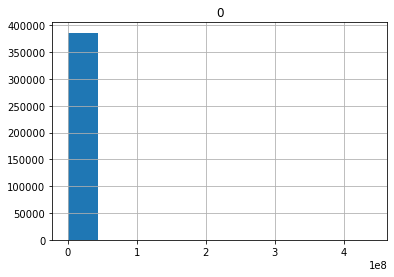

In [72]:
hist = pd.DataFrame(data["valeur_fonciere"].values).hist()

In [ ]:
# Représentation géographique des transactions

In [ ]:
# 

# Etape 3 : modélisation

In [85]:
# prix_m2
data['prix_m2'] = data['surface_terrain'] / data['valeur_fonciere']

# code_postal
data['code_postal'] = [x[-12:][:5] for x in data["adresse"].values]

# departement
data['departement'] = [x[:2] for x in data['code_postal'].values]

display(data['departement'].unique())
data.head()

array([' 1', 'ss', 'll', 'ge', 'en', 'us', 'ie', 'rg', 'ro', 'se', 'au',
       ' 2', ' 3', '42', 'ch', ' 4', ' 5', ' 6', 'Ga', 'ra', 'né', 'ti',
       'ic', 'ei', 'to', 'bi', 'gn', 'be', 'ne', ' 7', '48', ' 8', 'he',
       ' 9', '10', 'ye', '11', 'nn', '12', '13', 'nc', 'ea', 'iè', 'ad',
       'ma', 'ue', '14', 'ug', 'Me', '15', '43', '16', 'sl', 'êm', '17',
       '18', '19', '21', '22', 'eu', 'na', 'ce', '23', 're', '24', '33',
       '25', 'ço', '26', 'ag', 'ur', '27', 'rr', 'in', '28', 'uc', 'er',
       '29', 'es', '20', 'ci', 'nz', 'an', '30', 'me', 'ri', '31', '32',
       'ia', 'le', 'ho', 'rè', '34', 'Le', '35', 'pi', 'ar', 'oi', '36',
       '37', '38', 'bl', '39', '40', 'sa', 'Da', '41', 'tt', 'so', '44',
       'te', 'dr', 'ez', 'ir', 'et', 'la', '45', 'gr', 'on', 'èr', 'ay',
       '46', '47', '49', 'jo', 'ou', 'mu', 'io', '50', '51', '52', 'im',
       '53', 'va', '54', '55', '56', 'de', 'ha', '58', 'is', '59', 'ni',
       'ai', 'sé', 'sc', 'èl', 'qu', 'ua', 'ol', 'l

,date_mutation,nature_mutation,valeur_fonciere,code_postal,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,adresse,identifiant_transaction,prix_m2,departement
2,2021-01-06,Vente,10.0,1290,1,NaN,NaN,NaN,culture,530.0,4.844368,46.224233,0 B043 ROUGEMONT Bey 1290 France,0 B043 ROUGEMONT Bey 1290 France le 2021-01-06,53.000000,1
3,2021-01-04,Vente,204332.0,1310,1,Maison,88.0,4.0,sols,866.0,5.157688,46.200988,7 0276 ALL DES ECUREUILS Buellas 1310 France,7 0276 ALL DES ECUREUILS Buellas 1310 France...,0.004238,1
6,2021-01-04,Vente,36.3,1250,1,NaN,NaN,NaN,culture,121.0,5.462947,46.256243,0 B077 COMBET MAILLET Corveissiat 1250 France,0 B077 COMBET MAILLET Corveissiat 1250 Franc...,3.333333,1
9,2021-01-11,Vente,400.0,1310,1,NaN,NaN,NaN,culture,460.0,5.115375,46.211715,0 B085 PRE BROUILLET Montcet 1310 France,0 B085 PRE BROUILLET Montcet 1310 France le ...,1.150000,1
12,2021-01-07,Vente,4780.0,1340,1,NaN,NaN,NaN,culture,7105.0,5.158681,46.387845,0 B013 BERARDAN Foissiat 1340 France,0 B013 BERARDAN Foissiat 1340 France le 2021...,1.486402,1


# Début preprocessing Eloi

In [163]:
# Les fichiers sont renommés valeursfoncieres-(année)

def preprocessing(year):
    # path = 'Users\victo\Desktop\ENSAE\Python\tokenisation-immo\valeursfoncieres-'+str(year)+'.csv'
    table = pd.read_csv('data/valeursfoncieres-'+ str(year) +'.csv', sep = ',')
    
    a = [2, 4, 5, 6, 7, 8, 9, 10, 12, 29, 31, 32, 38, 39, 40] 
    # vecteur des n° des colonnes qui nous intéressent
    
    a = [k - 1 for k in a]
    
    table = table[table.columns[a]]

    ventes_types = list(table[table.columns[1]].unique())
    
    table = table[(table['nature_mutation'] == 'Vente') | 
                  (table['nature_mutation'] == "Vente en l'état futur d'achèvement")]

    table = table[(table['nombre_lots'] == 0) | (table['nombre_lots'] == 1)]

    table = table[table['surface_reelle_bati']!=0]

    table = table[table['surface_reelle_bati'].notna()]

    table = table[table['valeur_fonciere'].notna()]
    
    table['adresse_numero'] = table['adresse_numero'].fillna('0').astype(int)
    table['adresse_suffixe'] = table['adresse_suffixe'].fillna(' ')
    table['adresse_code_voie'] = table['adresse_code_voie'].fillna(' ')
    table['adresse_nom_voie'] = table['adresse_nom_voie'].fillna(' ')
    table['code_postal'] = table['code_postal'].fillna('0').astype(int)
    table['nom_commune'] = table['nom_commune'].fillna(' ')

    table['Adresse'] = table['adresse_numero'].astype(str) + ' ' + table['adresse_suffixe'] + ' ' + table['adresse_code_voie'] + ' ' + table['adresse_nom_voie'] + ' ' + table['nom_commune'] + ' ' + table['code_postal'].astype(str) + ' ' + 'France'    
    
    table.reset_index(drop = True, inplace = True)
  
    return table

In [168]:
test = preprocessing(2017)

C:\Users\victo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (10,12,14,16,17,18,20,22,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [173]:
display(len(test))
test.head()

1140324

,date_mutation,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,nom_commune,nombre_lots,type_local,surface_reelle_bati,surface_terrain,longitude,latitude,Adresse
0,2017-01-03,Vente,258000.0,11,,IMP DES PINSONS,0384,1000,Saint-Denis-lès-Bourg,0,Appartement,22.0,655.0,5.205776,46.197455,11 0384 IMP DES PINSONS Saint-Denis-lès-Bour...
1,2017-01-03,Vente,258000.0,11,,IMP DES PINSONS,0384,1000,Saint-Denis-lès-Bourg,0,Appartement,22.0,655.0,5.205776,46.197455,11 0384 IMP DES PINSONS Saint-Denis-lès-Bour...
2,2017-01-03,Vente,258000.0,11,,IMP DES PINSONS,0384,1000,Saint-Denis-lès-Bourg,0,Appartement,120.0,655.0,5.205776,46.197455,11 0384 IMP DES PINSONS Saint-Denis-lès-Bour...
3,2017-01-05,Vente,175050.0,11,,SAINT MICHEL,B244,1370,Val-Revermont,0,Maison,99.0,471.0,5.361589,46.274684,11 B244 SAINT MICHEL Val-Revermont 1370 France
4,2017-01-06,Vente,162000.0,6,,RUE LOUIS BLERIOT,2330,1000,Bourg-en-Bresse,1,Appartement,69.0,NaN,5.233978,46.211926,6 2330 RUE LOUIS BLERIOT Bourg-en-Bresse 100...


In [174]:
test.drop_duplicates(subset = ['date_mutation', 'valeur_fonciere', 'adresse_nom_voie'], keep='last')
test.head()

,date_mutation,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,nom_commune,nombre_lots,type_local,surface_reelle_bati,surface_terrain,longitude,latitude,Adresse
0,2017-01-03,Vente,258000.0,11,,IMP DES PINSONS,0384,1000,Saint-Denis-lès-Bourg,0,Appartement,22.0,655.0,5.205776,46.197455,11 0384 IMP DES PINSONS Saint-Denis-lès-Bour...
1,2017-01-03,Vente,258000.0,11,,IMP DES PINSONS,0384,1000,Saint-Denis-lès-Bourg,0,Appartement,22.0,655.0,5.205776,46.197455,11 0384 IMP DES PINSONS Saint-Denis-lès-Bour...
2,2017-01-03,Vente,258000.0,11,,IMP DES PINSONS,0384,1000,Saint-Denis-lès-Bourg,0,Appartement,120.0,655.0,5.205776,46.197455,11 0384 IMP DES PINSONS Saint-Denis-lès-Bour...
3,2017-01-05,Vente,175050.0,11,,SAINT MICHEL,B244,1370,Val-Revermont,0,Maison,99.0,471.0,5.361589,46.274684,11 B244 SAINT MICHEL Val-Revermont 1370 France
4,2017-01-06,Vente,162000.0,6,,RUE LOUIS BLERIOT,2330,1000,Bourg-en-Bresse,1,Appartement,69.0,NaN,5.233978,46.211926,6 2330 RUE LOUIS BLERIOT Bourg-en-Bresse 100...


In [6]:
# Fonction pour mettre dans 'dicte' les 4 csv après preprocessing

dicte = {}
years = [2017,2018,2019,2020]
for k in years:
    dicte[k-2017] = preprocessing(k)

C:\Users\victo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (10,12,14,16,17,18,20,22,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\victo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (10,12,14,16,17,18,20,22,26,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [7]:
output = pd.DataFrame()
for k in range(4):
    output = pd.concat((output,dicte[k]), axis = 0)

In [13]:
output = output[['date_mutation', 'nature_mutation', 'valeur_fonciere', 'type_local', 
                 'surface_reelle_bati', 'surface_terrain', 'Adresse', 'latitude', 'longitude']]
output.sample(10)

,date_mutation,nature_mutation,valeur_fonciere,type_local,surface_reelle_bati,surface_terrain,Adresse,latitude,longitude
0,2017-01-03,Vente,258000.0,Appartement,22.0,655.0,11 0384 IMP DES PINSONS Saint-Denis-lès-Bour...,46.197455,5.205776
1,2017-01-03,Vente,258000.0,Appartement,22.0,655.0,11 0384 IMP DES PINSONS Saint-Denis-lès-Bour...,46.197455,5.205776
2,2017-01-03,Vente,258000.0,Appartement,120.0,655.0,11 0384 IMP DES PINSONS Saint-Denis-lès-Bour...,46.197455,5.205776
3,2017-01-05,Vente,175050.0,Maison,99.0,471.0,11 B244 SAINT MICHEL Val-Revermont 1370 France,46.274684,5.361589
4,2017-01-06,Vente,162000.0,Appartement,69.0,NaN,6 2330 RUE LOUIS BLERIOT Bourg-en-Bresse 100...,46.211926,5.233978
...,...,...,...,...,...,...,...,...,...
1060421,2020-12-16,Vente,1937500.0,Appartement,64.0,447.0,24 1748 RUE CHANOINESSE Paris 4e Arrondissem...,48.854301,2.350486
1060422,2020-12-16,Vente,1937500.0,Appartement,40.0,447.0,24 1748 RUE CHANOINESSE Paris 4e Arrondissem...,48.854301,2.350486
1060423,2020-12-16,Vente,1937500.0,Appartement,33.0,447.0,24 1748 RUE CHANOINESSE Paris 4e Arrondissem...,48.854301,2.350486
1060424,2020-12-16,Vente,1937500.0,Appartement,27.0,447.0,24 1748 RUE CHANOINESSE Paris 4e Arrondissem...,48.854301,2.350486


In [14]:
# fonction pour exporter le final en div=10 petits fichiers

div=10
for k in range(div):
    name='final-'+str(1+k)+'.csv'
    df=output[k*round(len(output)/div):(k+1)*round(len(output)/div)]
    df.to_csv(name,index=False,header=True)

# Etape 2 : création du modèle pour obtenir le prix moyen du voisinage (BallTree)

### 2.1. Importation des données

data_vf : base de données de l'INSEE sur l'historique des valeurs foncières

data_communes : base de données de l'INSEE sur les communes françaises

In [99]:
# importation de data_vf
div = 10
data_vf = pd.read_csv('data/final-1.csv', sep = ',')
for k in range(1, div):
    name = 'data/final-' + str(1 + k) + '.csv'
    data_vf = pd.concat([data_vf, pd.read_csv(name, sep = ',')])
    
# importation de data_communes
data_communes = pd.read_csv('communes_insee.csv', sep = ';')

# importation de data_regions
data_regions = pd.read_csv('communes-departement-region.csv', sep = ',')

C:\Users\victo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (0,15,100) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 2.2. Visualisation des DataFrames

In [131]:
# Visualisation de data_vf
print("Nombre de lignes de data data_vf :")
print(len(data_vf))
print("Nombre de colonnes de data data_vf :")
print(len(data_vf.columns))
print("Visualisation de data_vf :")
data_vf.sample(3)

Nombre de lignes de data data_vf :
4570326
Nombre de colonnes de data data_vf :
9
Visualisation de data_vf :


,date_mutation,nature_mutation,valeur_fonciere,type_local,surface_reelle_bati,surface_terrain,Adresse,latitude,longitude
441354,2017-04-25,Vente,88000.0,Maison,162.0,162.0,4 7680 CITE TATTEGRAIN Amiens 80000 France,49.906171,2.275168
91820,2017-07-31,Vente,8000000.0,Appartement,38.0,8399.0,14 3860 RUE DE LA POTERIE Corbeil-Essonnes 9...,48.615961,2.484637
54059,2019-03-26,Vente,1860000.0,Local industriel. commercial ou assimilé,826.0,2751.0,2 0825 RUE DU CARRE NORGANDS Sautron 44880 F...,47.256058,-1.648939


In [132]:
# Visualisation de data_communes
print("Nombre de lignes de data data_communes :")
print(len(data_communes))
print("Nombre de colonnes de data data_communes :")
print(len(data_communes.columns))
print("Visualisation de data_communes :")
data_communes["REG"].unique()

Nombre de lignes de data data_communes :
36677
Nombre de colonnes de data data_communes :
101
Visualisation de data_communes :


array([82, 22, 83, 93, 21, 73, 91, 25, 54, 24, 74, 26, 53, 72, 43, 23, 94,
       52, 41, 31, 42, 11,  1,  2,  3,  4], dtype=int64)

In [134]:
# Visualisation de data_regions
print("Nombre de lignes de data data_regions :")
print(len(data_regions))
print("Nombre de colonnes de data data_regions :")
print(len(data_regions.columns))
print("Visualisation de data_regions :")
display(data_regions.sample(3))
len(data_regions["code_region"].unique())

Nombre de lignes de data data_regions :
39201
Nombre de colonnes de data data_regions :
15
Visualisation de data_regions :


,code_commune_INSEE,nom_commune_postal,code_postal,libelle_acheminement,ligne_5,latitude,longitude,code_commune,article,nom_commune,nom_commune_complet,code_departement,nom_departement,code_region,nom_region
593,2137,BUSSIARES,2810,BUSSIARES,NaN,49.076591,3.250262,137.0,NaN,Bussiares,Bussiares,2,Aisne,32.0,Hauts-de-France
22107,54207,FRAISNES EN SAINTOIS,54930,FRAISNES EN SAINTOIS,NaN,48.374206,6.060920,207.0,NaN,Fraisnes-en-Saintois,Fraisnes-en-Saintois,54,Meurthe-et-Moselle,44.0,Grand Est
36781,86217,ST CHRISTOPHE,86230,ST CHRISTOPHE,NaN,46.925281,0.374730,217.0,NaN,Saint-Christophe,Saint-Christophe,86,Vienne,75.0,Nouvelle-Aquitaine


19

In [135]:
df_co2 = pd.read_csv("https://koumoul.com/s/data-fair/api/v1/datasets/igt-pouvoir-de-rechauffement-global/convert")
df_co2.sample(3)

,INSEE commune,Commune,Agriculture,Autres transports,Autres transports international,CO2 biomasse hors-total,Déchets,Energie,Industrie hors-énergie,Résidentiel,Routier,Tertiaire
23240,60100,BRASSEUSE,1538.331660,NaN,NaN,2394.771227,10.976179,202.491966,594.364348,39.076745,23014.428150,39.718386
30803,76734,VERGETOT,1296.257937,NaN,NaN,365.890566,57.261273,9.418231,27.644853,170.448959,1702.040285,207.205557
8512,24425,SAINT-JEAN-DE-COLE,694.270708,NaN,NaN,505.694625,157.602559,87.118636,255.714894,210.327122,654.762001,174.186658


2.3. Création d'une BDD inédite

In [159]:
data_vf[data_vf.index.duplicated()]

,date_mutation,nature_mutation,valeur_fonciere,type_local,surface_reelle_bati,surface_terrain,Adresse,latitude,longitude
0,2017-03-03,Vente,190000.0,Maison,126.0,431.0,7 0046 RUE DES NOYERS Fossé 41330 France,47.633330,1.282117
1,2017-03-08,Vente,80000.0,Maison,40.0,NaN,24 0390 RUE DU GAZOMETRE Montrichard Val de ...,47.341854,1.179088
2,2017-03-08,Vente,80000.0,Maison,30.0,NaN,24 B 0390 RUE DU GAZOMETRE Montrichard Val de ...,47.341854,1.179088
3,2017-03-21,Vente,95000.0,Local industriel. commercial ou assimilé,271.0,1200.0,215 0070 RUE DE CHAMP CHARDON Mont-près-Cham...,47.556513,1.443888
4,2017-03-23,Vente,163000.0,Maison,79.0,626.0,5 0104 RUE DU 8 MAI 1945 Cour-Cheverny 41700...,47.513564,1.453183
...,...,...,...,...,...,...,...,...,...
457024,2020-12-16,Vente,1937500.0,Appartement,64.0,447.0,24 1748 RUE CHANOINESSE Paris 4e Arrondissem...,48.854301,2.350486
457025,2020-12-16,Vente,1937500.0,Appartement,40.0,447.0,24 1748 RUE CHANOINESSE Paris 4e Arrondissem...,48.854301,2.350486
457026,2020-12-16,Vente,1937500.0,Appartement,33.0,447.0,24 1748 RUE CHANOINESSE Paris 4e Arrondissem...,48.854301,2.350486
457027,2020-12-16,Vente,1937500.0,Appartement,27.0,447.0,24 1748 RUE CHANOINESSE Paris 4e Arrondissem...,48.854301,2.350486


In [158]:
data_new = data_vf.copy()
data_new.reset_index(drop=True, inplace=True)

# prix_m2
data_new['prix_m2'] = data_vf['surface_terrain'] / data_vf['valeur_fonciere']

# cp
data_new['cp'] = [x[-12:][:5] for x in data_vf["Adresse"].values]
# data_new.set_index('cp')

# dep
data_new['dep'] = [x[:2] for x in data_new['cp'].values]

# region


ValueError: cannot reindex from a duplicate axis

In [157]:
data_new

1    11   0384 IMP DES PINSONS Saint-Denis-lès-Bour...
1    24   0390 RUE DU GAZOMETRE Montrichard Val de ...
1    5013   0058 RTE DE SAINT PONS Anglès 81260 France
1    16   A005 RES DU GROS CHENE Bazincourt-sur-Ept...
1    140   0228 RUE CLEMENT ADER Beaumont 63110 France
1          14   0210 RUE DU BROUAGE Chauny 2300 France
1     4   0320 RUE JOSEPH VENDRE Heyrieux 38540 France
1    28   0280 RUE DE VILLEMARECHAL Nanteau-sur-Lun...
1    17 T 0887 AV DE L ILE MADAME Port-des-Barques ...
1      102   2560 RUE LEON GAMBETTA Douai 59500 France
Name: Adresse, dtype: object

In [150]:
# code_region
x = data_new["cp"].loc[2]
x

2     1000
2    41400
2    81260
2    27700
2    63370
2     2300
2    38440
2    77130
2    17550
2    59950
Name: cp, dtype: object

In [ ]:

data_regions["nom_region"].iloc[data_new[]]

In [ ]:
regions = 13
appart_old[‘Distance moyenne’]=np.zeros(len(appart_old))
appart_old[‘Indices voisins’]=np.zeros(len(appart_old))
models={}
regions=appart_old.Région.unique()
for k in range(len(regions)):
    name=’appart_’+regions[k]
    data=appart_old[appart_old.Région==regions[k]]
    data=data.reset_index(drop=True)
    models[k]=BallTree(data[[‘latitude_r’, ‘longitude_r’]].values, leaf_size=2, metric=’haversine’)
    save_obj(models[k], name)